# #1: create an environment and select the kernel
Here are the command I use for creating an env:

`conda create --name MotorSavings python=3.10`

Once you done that make sure that your notebook is connected to your env. You may need to close and reopen your program.
# Install all required packages
`pip install -r ../requirements.txt`

In [8]:
!pip install -r ../requirements.txt

# 1- Train the models

In [2]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from get_utils import return_ignore, get_loss
from plot import *
import matplotlib.pyplot as plt
from utils import get_rate
import pandas as pd
import seaborn as sb


#%matplotlib qt
#%matplotlib widget
%matplotlib inline

# Directory info
This is the format that I use for generating directory when I train models. I use the network size of 128 for all analysis.

In [3]:
folder_name = 'Sim_fixed_128_temp'
n_model = 40 # number of simulated networks
# sizes = [16,32,64,128,256]
sizes = [128]

# root_dir = '/Volumes/T9/MotorNet'
root_dir = os.path.join(os.path.expanduser('~'),'Documents/Data/MotorNet')
base_dir = root_dir
save_fig = os.path.join(os.path.expanduser('~'),'Dropbox/Projects/papers/MotorSavings/paper/figures_raw')

# Running all models for all phases of training and for different network sizes
This could take almost one day, depending on your system. 
### Skip this if you already have your networks  

In [18]:
!python ../model.py {0} {network_siz} {n_model} {0} {1} {'FF2'} {-8} {3201}

python(53943) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


model00...
model01...
model02...
model03...
model04...
model05...
model06...
model07...
model08...
model09...
model10...
model11...
model12...
model13...
model14...
model15...
model16...
model17...
model18...
model19...
model20...
model21...
model22...
model23...
model24...
model25...
model26...
model27...
model28...
model29...
model30...
model31...
model32...
model33...
model34...
model35...
model36...
model37...
model38...
model39...
Training FF2:   6%|█▎                   | 198/3201 [05:28<1:18:21,  1.57s/batch]Batch 200/3201 Done, mean position loss: 25.413262434005738
Batch 200/3201 Done, mean position loss: 25.65024684667587
Training FF2:  13%|██▋                  | 401/3201 [10:53<1:08:05,  1.46s/batch]Batch 400/3201 Done, mean position loss: 22.96782875776291
Batch 400/3201 Done, mean position loss: 23.576295313835146
Training FF2:  13%|██▋                  | 404/3201 [10:56<1:13:09,  1.57s/batch]Batch 400/3201 Done, mean position loss: 24.50606385707855
Batch 400/3201 Done, me

In [4]:
for n_s in sizes: # sizes
    network_siz = n_s
    !python ../model.py {1} {network_siz} {n_model} {0} {1}

model00...
model01...
model02...
model03...
model04...
model05...
model06...
model07...
model08...
model09...
model10...
model11...
model12...
model13...
model14...
model15...
model16...
model17...
model18...
model19...
model20...
model21...
model22...
model23...
model24...
model25...
model26...
model27...
model28...
model29...
model30...
model31...
model32...
model33...
model34...
model35...
model36...
model37...
model38...
model39...
Training growing_up:   0%|             | 99/20010 [05:51<16:23:52,  2.96s/batch]Batch 100/20010 Done, mean position loss: 66.82869108438491
Batch 100/20010 Done, mean position loss: 64.81650829792022
Training growing_up:   1%|            | 104/20010 [05:53<15:26:20,  2.79s/batch]Batch 100/20010 Done, mean position loss: 64.37057027578354
Batch 100/20010 Done, mean position loss: 65.50538749694825
Training growing_up:   0%|            | 100/20010 [06:00<17:40:26,  3.20s/batch]Batch 100/20010 Done, mean position loss: 95.08047663927078
Batch 100/20010 Done

# #1: Learing curves for all phases

In [4]:
ignore = return_ignore(folder_name,n_model,ff_coef=-8) # sometimes some of cpus fail so we want to ignore those models
loss = get_loss(folder_name,n_model,w=1,target=None,ignore=ignore)

In [5]:
for i in range(len(loss['FF2'])):
    loss['FF2'][i] = list(-1*np.array(loss['FF2'][i]))

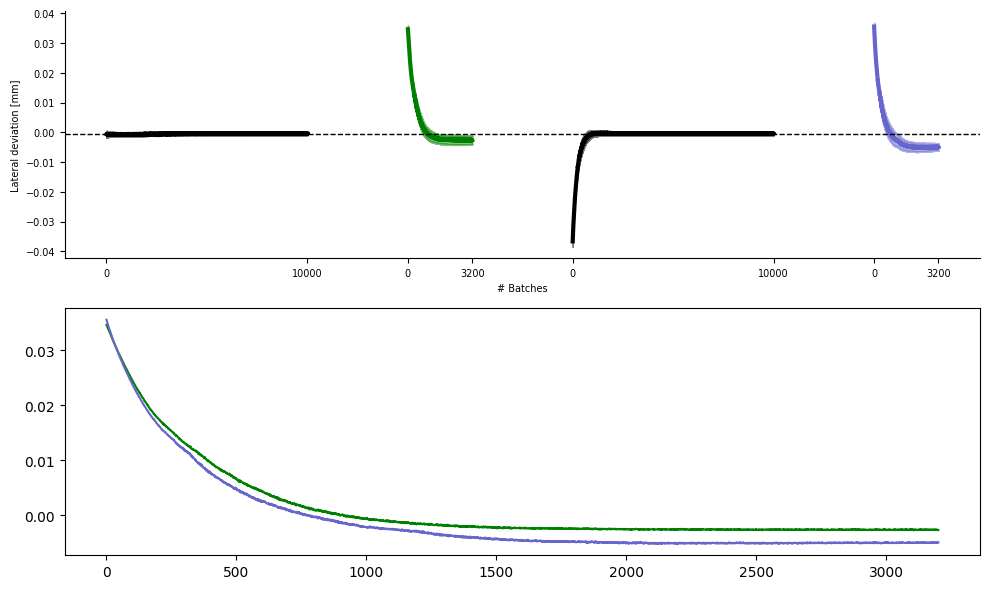

In [6]:
# Plot learning
fig, ax = plot_learning(loss,figsize=(10,6),show_saving=True,gap=5000) # (3.8,2.2)
plt.tight_layout()
plt.show()
#fig.savefig(os.path.join(save_fig,'learning_curve2.pdf'),dpi=300,bbox_inches='tight')

In [9]:
def get_initial_loss(loss):
    
    T = pd.DataFrame()

    # get initial loss
    data = {'NF1':[],'FF1':[],'NF2':[],'FF2':[]}
    for p in list(data.keys()):
        index=0
        if p=='NF1' or p=='NF2':
            # index=np.arange(-10,0)
            index = -1
        dat = np.array(loss[p])[:,index]
        if dat.ndim==1:
            dat = dat[:,None]
        data[p] = list(np.mean(dat,axis=1))

    T = create_dataframe(data)
    T['feature'] = 'init'
    
    return T

# #2: Do we have savings? 
Get the initial values of the loss and also the learning rate. It saves the result as a dataframe so that we don't need to run it every time.

In [10]:
# Create the dataframe
D = pd.DataFrame()

for n_s in sizes:
    network_siz = n_s
    fn = f'Sim_fixed_{network_siz}'

    ignore = return_ignore(fn,n_model,ff_coef=-8)
    loss = get_loss(fn,n_model,w=1,target=None,ignore=ignore)

    for i in range(len(loss['FF2'])):
        loss['FF2'][i] = list(-1*np.array(loss['FF2'][i]))

    R = get_rate(loss,w=5,check_fit=False)
    I = get_initial_loss(loss)

    R['size'] = network_siz
    I['size'] = network_siz

    T = pd.concat([R,I], ignore_index=True)

    D = pd.concat([D,T], ignore_index=True)

D.to_csv(base_dir+'/model_loss.csv',index=False)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# Plot the result only for network of size 128

In [16]:

# Define bootstrap function
def bootstrap_paired_test(a, b, n_bootstrap=10000):
    """Perform a bootstrap test for paired samples."""
    diffs = a - b  # Compute pairwise differences
    observed_mean = np.median(diffs)  # Observed mean difference

    # Bootstrap resampling: Shuffle sign of differences
    boot_medians = np.array([np.median(diffs * np.random.choice([-1, 1], size=len(diffs))) for _ in range(n_bootstrap)])

    # Compute p-value: Two-tailed test
    p_value = np.mean(np.abs(boot_medians) >= np.abs(observed_mean))
    
    return observed_mean, p_value

# Perform bootstrap paired test
obs_diff, p_value = bootstrap_paired_test(a, b)
print(obs_diff *1000)

# Display results
print(f'Observed Difference: {obs_diff}, p-value: {p_value}')

-821.9861192628492
Observed Difference: -0.8219861192628493, p-value: 0.0001


In [ ]:
from scipy.stats import ttest_rel

a = T[T['phase']=='FF1']['value'].values
b = T[T['phase']=='FF2']['value'].values

t_stat, p_value = ttest_rel(a, b, nan_policy='omit')
print(f't-statistic: {t_stat}, p-value: {p_value}')
print(np.mean(a-b)*1000)

t-statistic: -4.918637576543184, p-value: 1.618502722286073e-05
-908.3546494366577


(array([ 1.,  0.,  2.,  4., 13.,  6.,  8.,  4.,  1.,  1.]),
 array([-1.33680178e-03, -1.07676449e-03, -8.16727203e-04, -5.56689913e-04,
        -2.96652623e-04, -3.66153326e-05,  2.23421957e-04,  4.83459247e-04,
         7.43496537e-04,  1.00353383e-03,  1.26357112e-03]),
 <BarContainer object of 10 artists>)

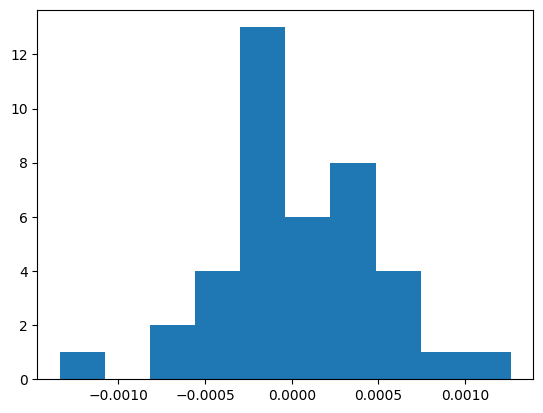

In [11]:
plt.hist(a-b)

In [20]:
np.mean(b-a)*1000

-0.1106694851841855

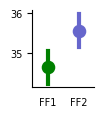

In [14]:
# Generate the plots
D = pd.read_csv(base_dir+'/model_loss.csv')
feature = 'init' # you can select 'init' or 'rate'

filter_condition = (
    (D['phase'].isin(['FF1', 'FF2'])) &
    (D['size'] == 128) &
    (D['feature'] == feature) # you can select 'init' or 'rate'
)
T = D[filter_condition].reset_index(drop=True)

T['value'] = T['value']*1000
# plot 
ax = my_pointplot(T,x='phase',y='value',hue='phase',linewidth=3,ax=None)
fig=ax.get_figure()
if feature == 'rate':
    fig.savefig(os.path.join(save_fig, 'saving_rate_control.pdf'), dpi=300, bbox_inches='tight')
else:
    fig.savefig(os.path.join(save_fig, 'saving_init_control.pdf'), dpi=300, bbox_inches='tight')

# Plot the result only for networks of all sizes

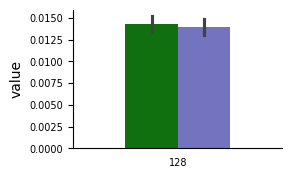

In [33]:
D = pd.read_csv(base_dir+'/model_loss.csv')
feature = 'rate' # you can select 'init' or 'rate'

filter_condition = (
    (D['phase'].isin(['FF1', 'FF2'])) &
    (D['feature'] == feature) # you can select 'init' or 'rate'
)
T = D[filter_condition].reset_index(drop=True)


# plot
fig,ax = my_barplot(T,x='size',y='value',hue='phase')
#fig.savefig(os.path.join(save_fig, 'perf_vs_size.pdf'), dpi=300, bbox_inches='tight')

# % of network that showed saving vs. network size

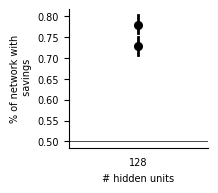

In [17]:
D = pd.read_csv(base_dir+'/model_loss.csv')
fig = None
ax = None

linestyle=['-','--']

for i,feature in enumerate(['rate','init']):
#feature = 'init' # you can select 'init' or 'rate'

    filter_condition = (
        (D['phase'].isin(['FF1','FF2'])) &
        (D['feature'] == feature) &
        (D['size'] <512)  &
        (D['size'] > 16)
    )
    T = D[filter_condition].reset_index(drop=True)

    ff1_data = T[T['phase']=='FF1']
    ff2_data = T[T['phase']=='FF2']
    merged_data = pd.merge(ff1_data,ff2_data,on='size',suffixes=('_ff1', '_ff2'))
    # Calculate the difference in 'loss'
    if feature == 'init':
        merged_data['loss_difference'] = (-merged_data['value_ff2']+merged_data['value_ff1']>0 ) # <0 
    else:
        merged_data['loss_difference'] = (merged_data['value_ff2']-merged_data['value_ff1']>0) # >0

    # Plotting
    ax = my_pointplot(merged_data,x='size',y='loss_difference',hue=None,figsize=(1.8, 1.8),ax=ax,linewidth=2,color='black',linestyle=linestyle[i],xlabel='# hidden units',ylabel='% of network with\n savings')

ax.axhline(0.5, color='black', linestyle='-', label='Chance level',linewidth=0.5)

fig=ax.get_figure()
fig.savefig(os.path.join(save_fig,'saving_vs_size.pdf'),dpi=300,bbox_inches='tight')